In [1]:
import pandas as pd
from file_paths_and_consts import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('classic')
import seaborn as sns
import geopandas as gpd
import random
sns.set()
import os
SEED_VALUE = 590
random.seed(SEED_VALUE)

OUTPUT_DIR

'/project/biocomplexity/UKR_forecast/migration_data/output_data/'

In [2]:
import multiprocessing as mp
import numpy as np
def calc_attitude_parallel(num):
    return num**2,num**3

def multiproc_attitude(all_nums):
    cpus = 4#mp.cpu_count()
    #st_time = time.time()
    hh_splits = np.array_split(all_nums, cpus) #--this a list with multiple dataframe.. each dataframe is used by one core
    #print(hh_splits)
    pool_args = [h_chunk for h_idx,h_chunk in enumerate(hh_splits)]
    #print('total time taken to split',time.time()-st_time)
    pool = mp.Pool(processes = cpus)
    results = pool.map(calc_attitude_parallel, pool_args)
    pool.close()
    pool.join()
    return results

ss = []

for i in range(0,100):
    ss.append(i)
    
results = multiproc_attitude(ss)
print(type(results[0][1]))

<class 'numpy.ndarray'>


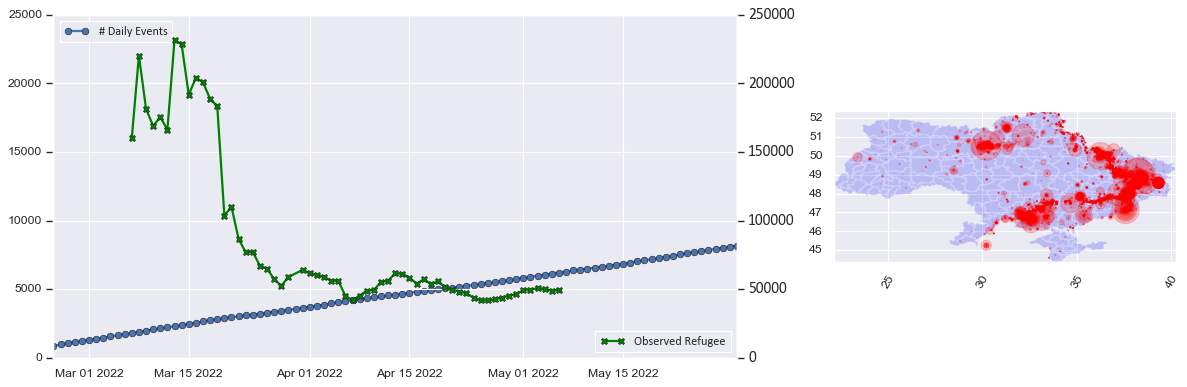

In [3]:
ROLLING = 7
conflict_data_file = UNCLEANED_DATA_DIR+'ukraine_conflict_data_feb_oct.csv'
refugee_data_file = GROUND_TRUTH_DIR+'ukraine_refugee_data_2.csv'
geo_shp_file = UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'

conflict_data = pd.read_csv(conflict_data_file)
conflict_data['time'] = pd.to_datetime(conflict_data['event_date'])
conflict_data = conflict_data.sort_values(by='time')
conflict_count = conflict_data[['time','fatalities']].groupby('time')['fatalities'].count().reset_index()
conflict_count['fatalities'] = conflict_count['fatalities'].cumsum()
conflict_count['fatalities'] = conflict_count['fatalities'].rolling(ROLLING).mean()
conflict_count = conflict_count.dropna(subset=['fatalities'])

refugee_data = pd.read_csv(refugee_data_file)
refugee_data['time'] = pd.to_datetime(refugee_data['time'])
refugee_data = refugee_data.sort_values(by='time')
refugee_data['refugee'] = refugee_data['refugee'].rolling(ROLLING).mean()
refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])

burundi_gdf = gpd.read_file(geo_shp_file)

fig,ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [2, 1]})
plt.xticks(rotation=60)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 12
rcParams["axes.labelsize"] = 16
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14

ax2 = ax[0].twinx()
ax2.plot(refugee_data['time'],refugee_data['refugee'],marker='X',linewidth=2,color='green',label='Observed Refugee')
ax[0].plot(conflict_count['time'],conflict_count['fatalities'],marker='o',linewidth=2,label='# Daily Events')
ax[0].set_xlim([datetime.date(2022, 2, 24), datetime.date(2022, 5, 31)])
#ax.set_ylim([conflict_count['fatalities'].min()-5,conflict_count['fatalities'].max()+5])
#ax2.set_ylim([refugee_data['refugee'].min()-500,refugee_data['refugee'].max()+500])
YLIM = [0,1000]
ax[0].legend(loc='upper left')
ax2.legend(loc='lower right')
#ax[0].set_ylim(YLIM)
fig.tight_layout()

burundi_gdf.plot(ax=ax[1],color='blue',alpha=0.2)
EPS = 0.1
SCALE = 2
conflict_data_gdf = gpd.GeoDataFrame(conflict_data,geometry=gpd.points_from_xy(conflict_data.longitude,conflict_data.latitude))
conflict_data_gdf.plot(ax=ax[1],color='red',alpha=0.2,markersize=(conflict_data['fatalities']+EPS)*SCALE)
ax[1].set_xlim(burundi_gdf.total_bounds[0], burundi_gdf.total_bounds[2])
ax[1].set_ylim(burundi_gdf.total_bounds[1], burundi_gdf.total_bounds[3])
fig.tight_layout()

In [7]:
all_ids = burundi_gdf['ADM2_EN'].tolist()

In [17]:
def get_results_for_2(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7):
    
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'__completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR+f2_name):
            true_f_name = f2_name
        else:
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

def get_raion_list(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7):
    
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
            all_dfs.append(cur_id)
        else:
            continue
            
    return set(all_dfs)

#get_results_for(777,prefix='mim')
def get_uncertainty_results(hyper_comb, region_name="all",prefix='fresh_calib_batch_simulation'):
    all_dfs = []
    if region_name=="all":
        col_to_sum = ['refugee','old_people','child','male','female']
        for cur_id in all_ids:
            f_name = prefix+'_result_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
            if os.path.isfile(OUTPUT_DIR+f_name):
                cur_df = pd.read_csv(OUTPUT_DIR+f_name)
                cur_df['time'] = pd.to_datetime(cur_df['time'])
                cur_df = cur_df.sort_values(by=['time','refugee'],ascending=[True,False])
                
                cur_df = cur_df.drop_duplicates(subset=['time'],keep='first')
                all_dfs.append(cur_df)
    return all_dfs

In [9]:
# ## compare if result looks same for a raion against two runs
# df1 = get_results_for_2(99950,region_name=['Kyiv'],prefix='mim_result')
# df2 = get_results_for_2(99969,region_name=['Kyiv'],prefix='mim_result')

# rcParams["font.family"] = "calibri"
# rcParams["font.size"] = 32
# rcParams["axes.labelsize"] = 28
# rcParams["axes.titlesize"] = 28
# rcParams["xtick.labelsize"] = 26
# rcParams["ytick.labelsize"] = 26

# fig,ax = plt.subplots(figsize=(14,5))
# plt.xticks(rotation=30)

# ax.plot(df1['time'],df1['refugee'],label='99950')
# ax.plot(df2['time'],df2['refugee'],label='99960')

# ax.set_xlim([datetime.date(2022, 3, 7), datetime.date(2022, 5, 6)])
# ax.legend(loc='best')
# df1['refugee'].corr(df2['refugee'])


In [10]:
r1 = get_raion_list(99950,prefix='mim_result')
r2 = get_raion_list(500,prefix='mim_result')
r1-r2

{'Berehivskyi',
 'Chortkivskyi',
 'Kovelskyi',
 'Krasnohvardiiskyi',
 'Krasnoperekopskyi',
 'Rozdilnianskyi',
 'Tiachivskyi',
 'Yaltynskyi'}

In [11]:
# HOUSEHOLD_DATA_PREFIX = 'ukraine_household_data_ADM2_HDX.csv'
# hh_df = pd.read_csv(HOUSEHOLD_DIR+HOUSEHOLD_DATA_PREFIX)
# hh_df.shape

In [12]:
# hh_cnt = hh_df['matching_place_id'].value_counts().reset_index().rename(columns={'index':'raion','matching_place_id':'hh'})

In [13]:
hh_cnt = pd.read_csv('hh_cnts.csv')

## UNCERTAINTY PLOTS FOR 

#### Create the data

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.style.use('classic')
import seaborn as sns
sns.set()

def get_uncertainty(sim_indices,first_df,q1=0.25,q3=0.75):
    #first_df = first_df[0:sz]
    run_cols = [str(i) for i in sim_indices if str(i) in first_df.columns.tolist()]
    medians = first_df[run_cols].median(axis=1)
    q1 = first_df[run_cols].quantile(q1, axis=1)
    q3 = first_df[run_cols].quantile(q3, axis=1)
    return medians,q1,q3

#simulation_indices = [10060,10061,10062,10063,10064,10065,10066,10067,10068,10069]
#simulation_indices = [30000,30001,30002,30003,30004,30005,30006]
#simulation_indices = [40000,40001,40002,40003,40004,40005,40006]
#simulation_indices = [50000,50001,50002,50003,50004,50005,50006]
#simulation_indices = [50006,50007,50008,50009,50010,50011]
#simulation_indices = [2000,2001,2004,2005]


In [26]:
simulation_indices = [99990+i for i in range(1,10)]
simulation_indices = [100+i for i in range(0,10)]
simulation_indices = [100+i for i in range(3,8)]+[109]
simulation_indices = [105,106]+[109]
#[3-4,3-3,4-4,2-2,1-1-,5-5,6-6]
simulation_indices = [99950,99951,99960,99961,99962,99964,99966,99968,99969]
#simulation_indices = [99900,99901,99902,99903,99950]
simulation_indices = [500,501,502,503,504,505,506,507,508]

first_df = []
second_df = []

for vv in simulation_indices:
    print(vv,end=' ')
    current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING)
    current_df['comb'] = str(vv)
    #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
    #current_df_unsmoothed['comb'] = str(vv)

    first_df.append(current_df)
    #second_df.append(current_df_unsmoothed)
first_df = pd.concat(first_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
#print(first_df.head())
# mm = 1.5
# ss = 38
# for col in simulation_indices:
#     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
    #print(first_df.head())
#second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

500 112 raions found
501 112 raions found
502 112 raions found
503 112 raions found
504 112 raions found
505 112 raions found
506 111 raions found
507 102 raions found
508 111 raions found


In [31]:
refugee_data_2 = pd.read_csv('ukr_refugee_src_2.csv')
refugee_data_2['time'] = pd.to_datetime(refugee_data_2['time'])
refugee_data_2 = refugee_data_2.sort_values(by='time')
refugee_data_2['refugee'] = refugee_data_2['daily'].rolling(ROLLING).mean()
refugee_data_2 = refugee_data_2.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])
refugee_data_2

time  cumulative   daily        refugee
6  2022-03-02      989560  170799  141365.714286
7  2022-03-03     1173690  184130  156354.428571
8  2022-03-04     1343790  170100  166323.571429
9  2022-03-05     1540463  196673  173957.571429
10 2022-03-06     1742987  202524  178936.285714
..        ...         ...     ...            ...
90 2022-05-25     6652164   48379   46706.285714
91 2022-05-26     6700411   48247   46780.428571
92 2022-05-27     6737208   36797   44601.142857
93 2022-05-28     6771963   34755   42605.428571
94 2022-05-29     6801987   30024   41004.285714

[89 rows x 4 columns]

## Do specifying different cores and memory change result apart from stochasticity?

500 501 502 503 504 505 506 507 508 [19052. 19066. 19083. 19097. 19113. 19127.]


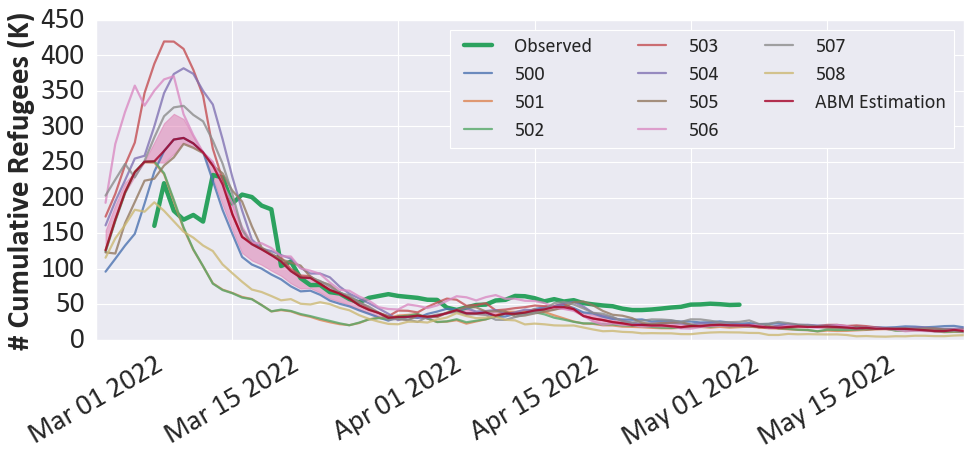

In [32]:
import datetime

trim = 7

median_normal,q1_normal,q3_normal = get_uncertainty(simulation_indices,first_df,q1=0.4,q3=0.6)
# median_esc,q1_esc,q3_esc = get_uncertainty(simulation_indices[10:-trim],first_df)

# median_normal_unsmooth,q1_normal_unsmooth,q3_normal_unsmooth = get_uncertainty(simulation_indices[0:10-trim],second_df)
# median_esc_unsmooth,q1_esc_unsmooth,q3_esc_unsmooth = get_uncertainty(simulation_indices[10:-trim],second_df)

# median_normal,q1_normal,q3_normal = get_uncertainty([check_single],first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty([check_single+1],first_df)
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(14,5))
plt.xticks(rotation=30)

ax.plot(refugee_data['time'], refugee_data['refugee']/1000,label='Observed',linewidth=4,color='#2ca25f')
#ax.plot(refugee_data_2['time'], refugee_data_2['refugee']/1000,label='Observed 2',linewidth=8,color='black')

for p in simulation_indices:
    print(p,end=' ')
    try:
        new_series = first_df[str(p)].copy()
        ax.plot(first_df['time'],new_series/1000,linewidth=2,alpha=0.8,label=str(p))
    except Exception as e:
        print(e)
        continue

ax.plot(first_df['time'],median_normal/1000,linewidth=2,color='#a50026',alpha=0.8,label='ABM Estimation')
ax.fill_between(first_df["time"], q1_normal/1000, q3_normal/1000, color='#de77ae',alpha=0.5)
ax.legend(loc='best',ncol=3,fontsize=18)
ax.set_ylabel("# Cumulative Refugees (K)",fontweight='bold')
ax.set_xlim([datetime.date(2022, 3, 1), datetime.date(2022, 5, 29)])
#ax.set_ylim([0,300])
print(ax.get_xticks())

## RAM USAGE and RUNTIME vs hh sizes

0.0 core
(120, 7)
1 core
(120, 7)
2 core
(120, 7)
4 core
(120, 7)
6.0 core
(120, 7)
8 core
(120, 7)
16 core
(120, 7)


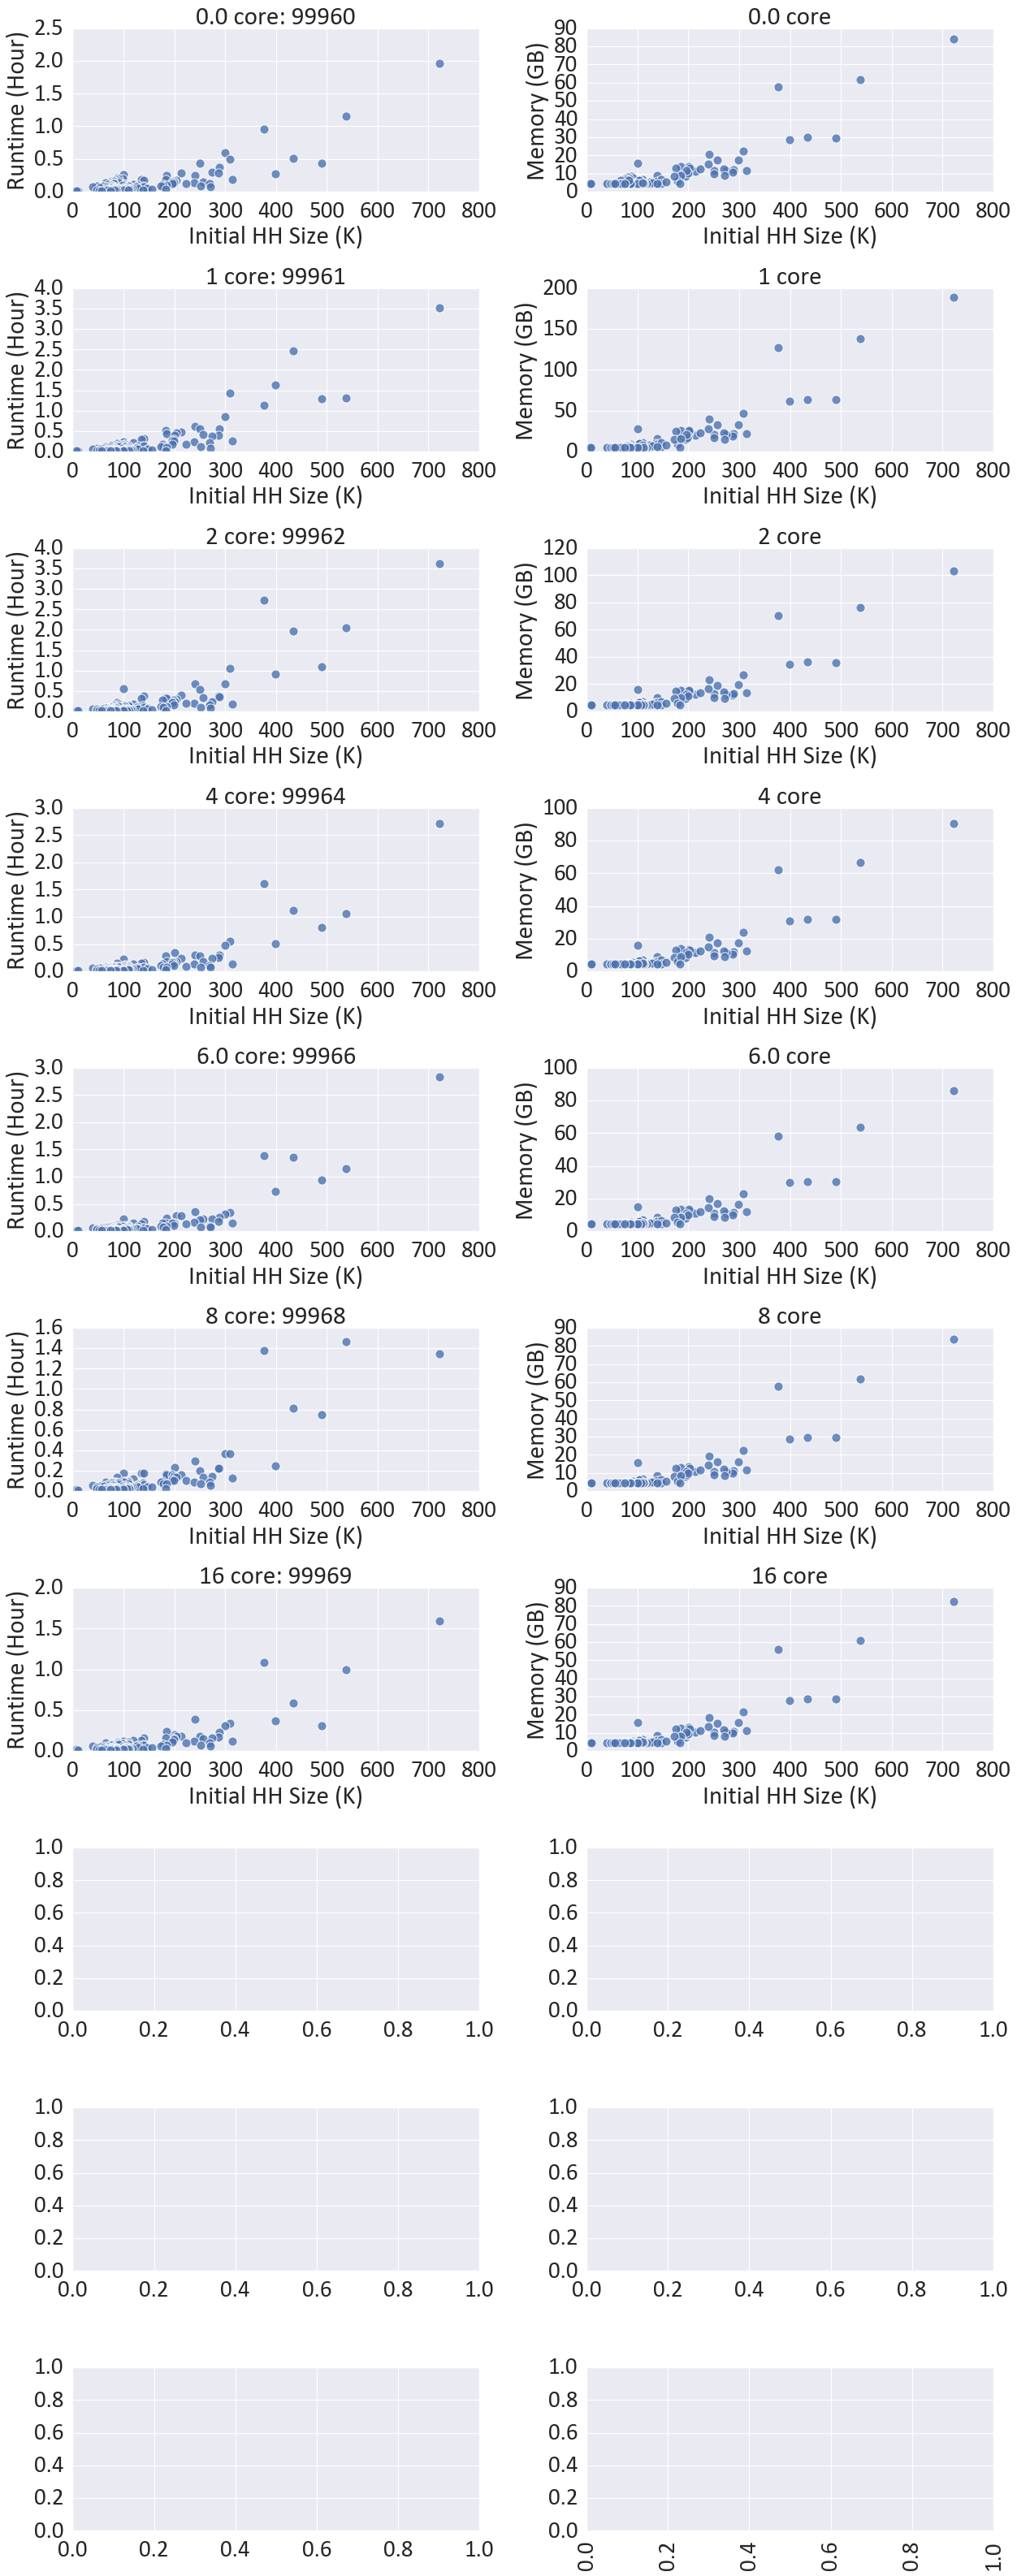

In [16]:
import pandas as pd


runtime_df = pd.read_csv('../runtime_log/runtime_raion_for_paper.csv')
runtime_df = runtime_df.drop_duplicates(subset=['raion','hyper_comb'],keep='last')

rcParams["font.size"] = 18
fig,ax = plt.subplots(10,2,figsize=(16,40))
plt.xticks(rotation=90)

sq_i = [-2,0,1,2,2.46,3,4]
for idx,i in enumerate([99960,99961,99962,99964,99966,99968,99969]):
    print(round(2**sq_i[idx],0),'core')
    cur_runtime_df = runtime_df[runtime_df.hyper_comb==i].sort_values(by='runtime',ascending=False)
    profile_hh_with_something = cur_runtime_df.merge(hh_cnt,on='raion',how='inner')
#profile_hh_with_something
    print(profile_hh_with_something.shape)
#     for hh_cap in [100000,200000,300000,400000,500000,600000,700000,800000]:
#         runtime_cap = profile_hh_with_something[profile_hh_with_something.hh<=hh_cap]['runtime'].max()/60
#         memory_cap = profile_hh_with_something[profile_hh_with_something.hh<=hh_cap]['memory_consumed'].max()/1000000
#         print(hh_cap,runtime_cap,'minutes',memory_cap,'GB')
    
    ax[idx][0].scatter(profile_hh_with_something['hh']/1000,profile_hh_with_something['runtime']/3600,s=100,alpha=0.8)
    ax[idx][0].set_ylim([0,None])
    ax[idx][0].set_xlim([0,None])
    ax[idx][0].set_xlabel('Initial HH Size (K)')
    ax[idx][0].set_ylabel('Runtime (Hour)')
    
    ax[idx][1].scatter(profile_hh_with_something['hh']/1000,profile_hh_with_something['memory_consumed']/1000000,s=100,alpha=0.8)
    ax[idx][1].set_ylim([0,None])
    ax[idx][1].set_xlim([0,None])
    ax[idx][1].set_xlabel('Initial HH Size (K)')
    ax[idx][1].set_ylabel('Memory (GB)')
    
    ax[idx][0].set_title(str(round(2**sq_i[idx],0))+' core: '+str(i))
    ax[idx][1].set_title(str(round(2**sq_i[idx],0))+' core')
    
fig.tight_layout()

## Observation for 1 core

### jobs with less than 100K initial households takes less than 20 minutes to run, we probably do not more than 1 core for them, they also need no more than 8.2 GB memory

### jobs with less than 200K initial households takes around 30 minutes to run, we probably do not more than 1 core for them, they also need no more than 26 GB memory

### jobs with less than 300K initial households takes around 1 hours to run, they also need no more than 48 GB memory

### There are only 8 jobs that has more than 300K households, these are the jobs that takes most amount of memory and runtime

## Observation for 2 core

### jobs with less than 100K initial households takes less than 10.7 minutes to run, highest memory is 5.2 GB

### jobs with less than 200K initial households takes around 20 minutes to run, we probably do not more than 1 core for them, they also need no more than 8.22 GB memory

### jobs with less than 300K initial households takes around 25 minutes to run, they also need no more than 16 GB memory

### There are only 8 jobs that has more than 300K households, these are the jobs that takes most amount of memory and runtime

# Hybrid method

### hh size<=100000 =  1 core , 8 GB
### hh size<=300000 =  2 core , 16 GB
### hh size<=600000 =  4 core , 32 GB
### hh size>600000 =  8 core ,64  GB

## job makespans



0.0 core
1 core
2 core
4 core
6.0 core
8 core
16 core


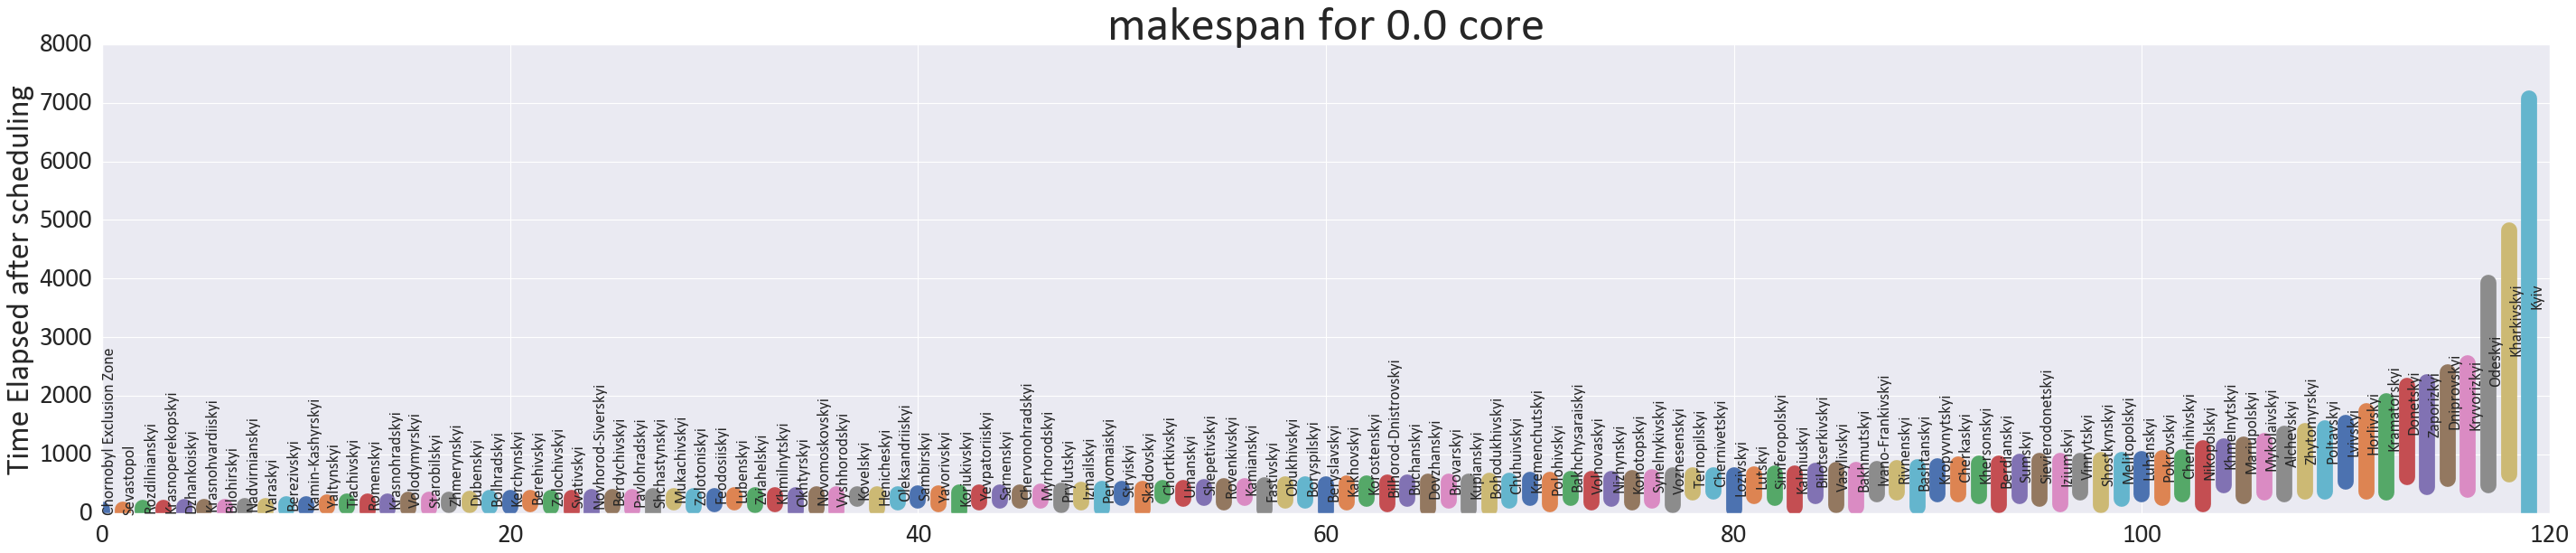

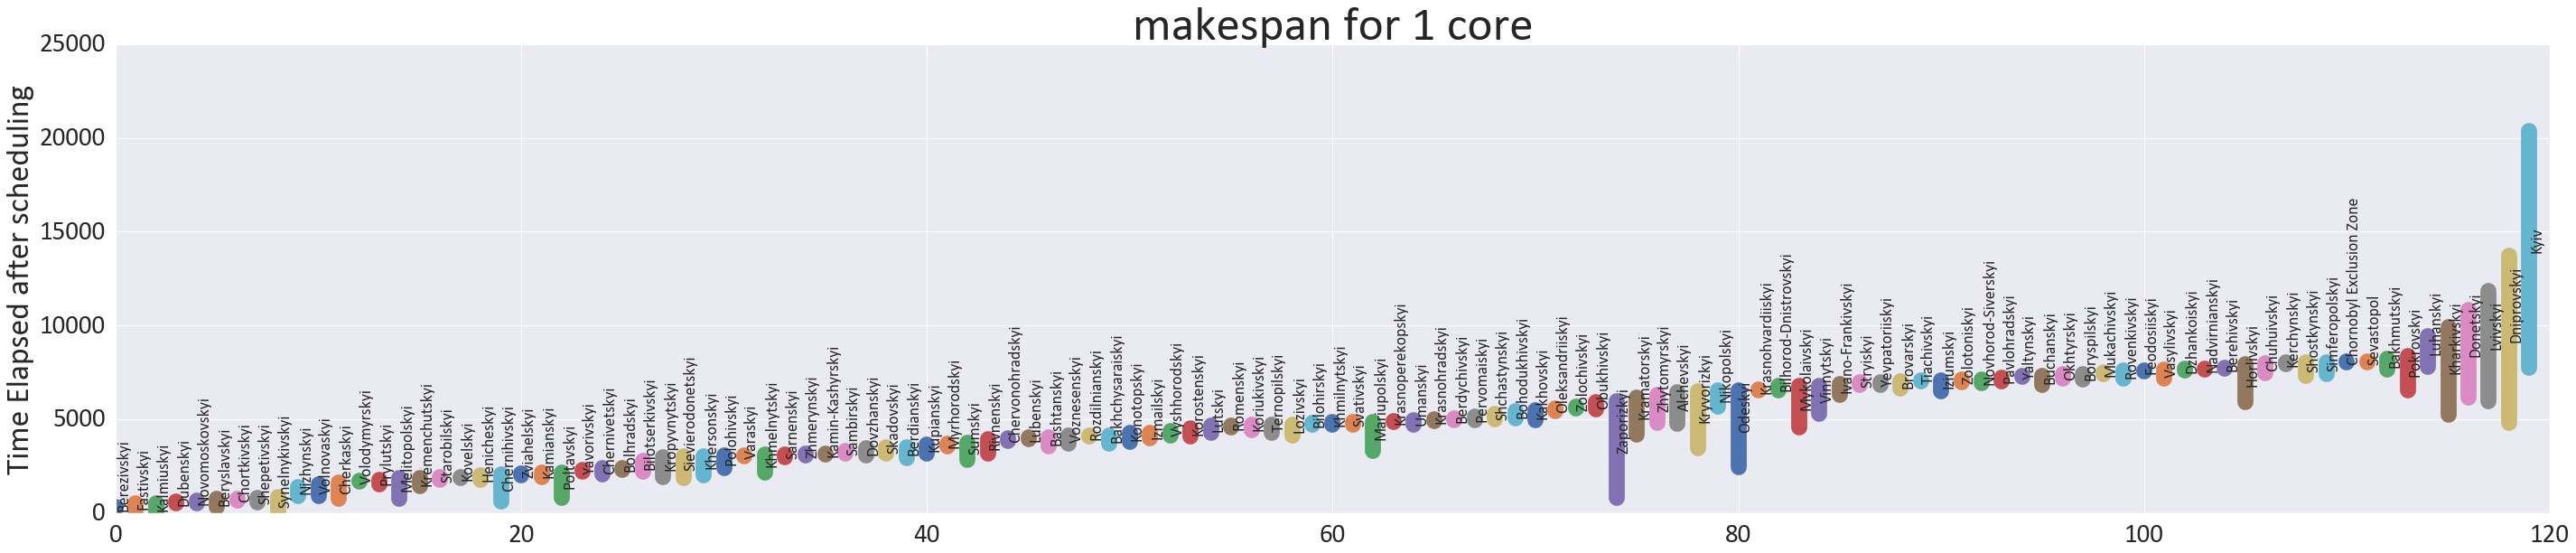

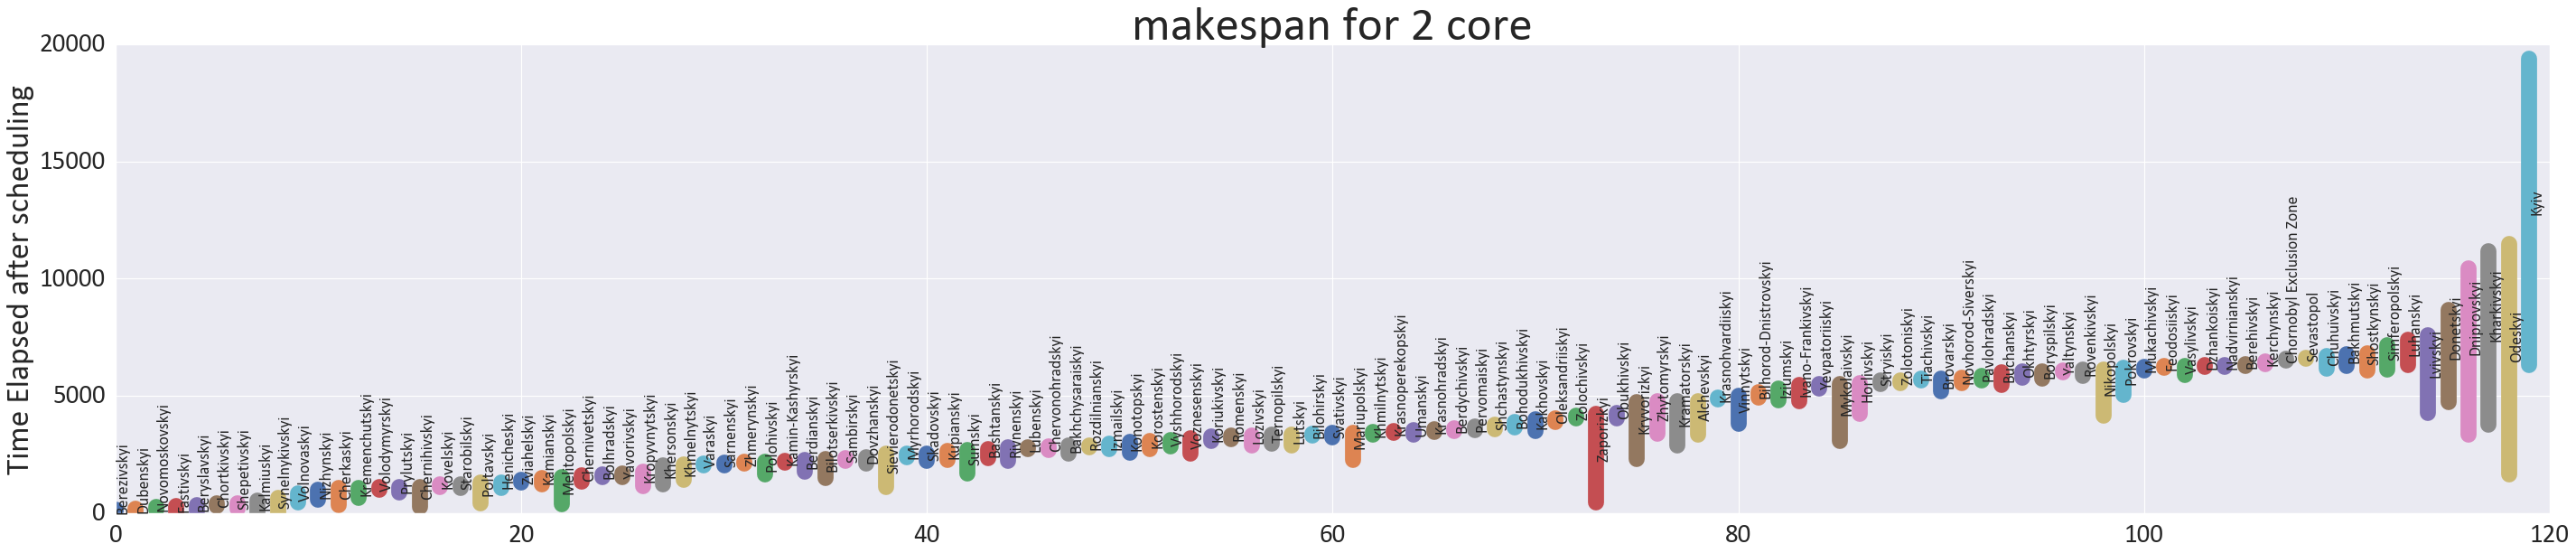

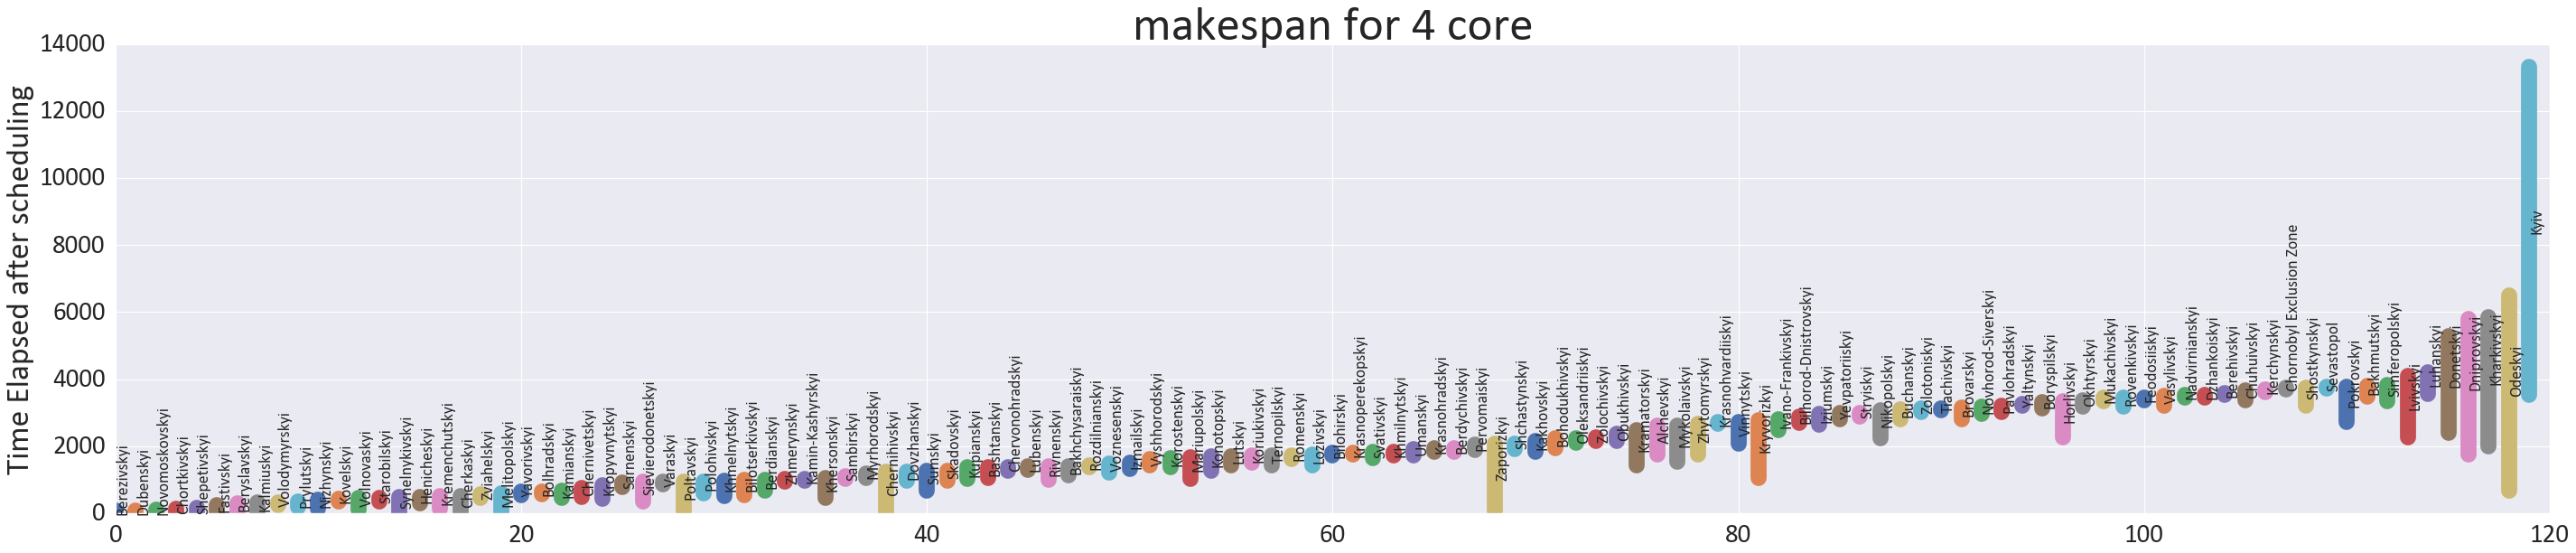

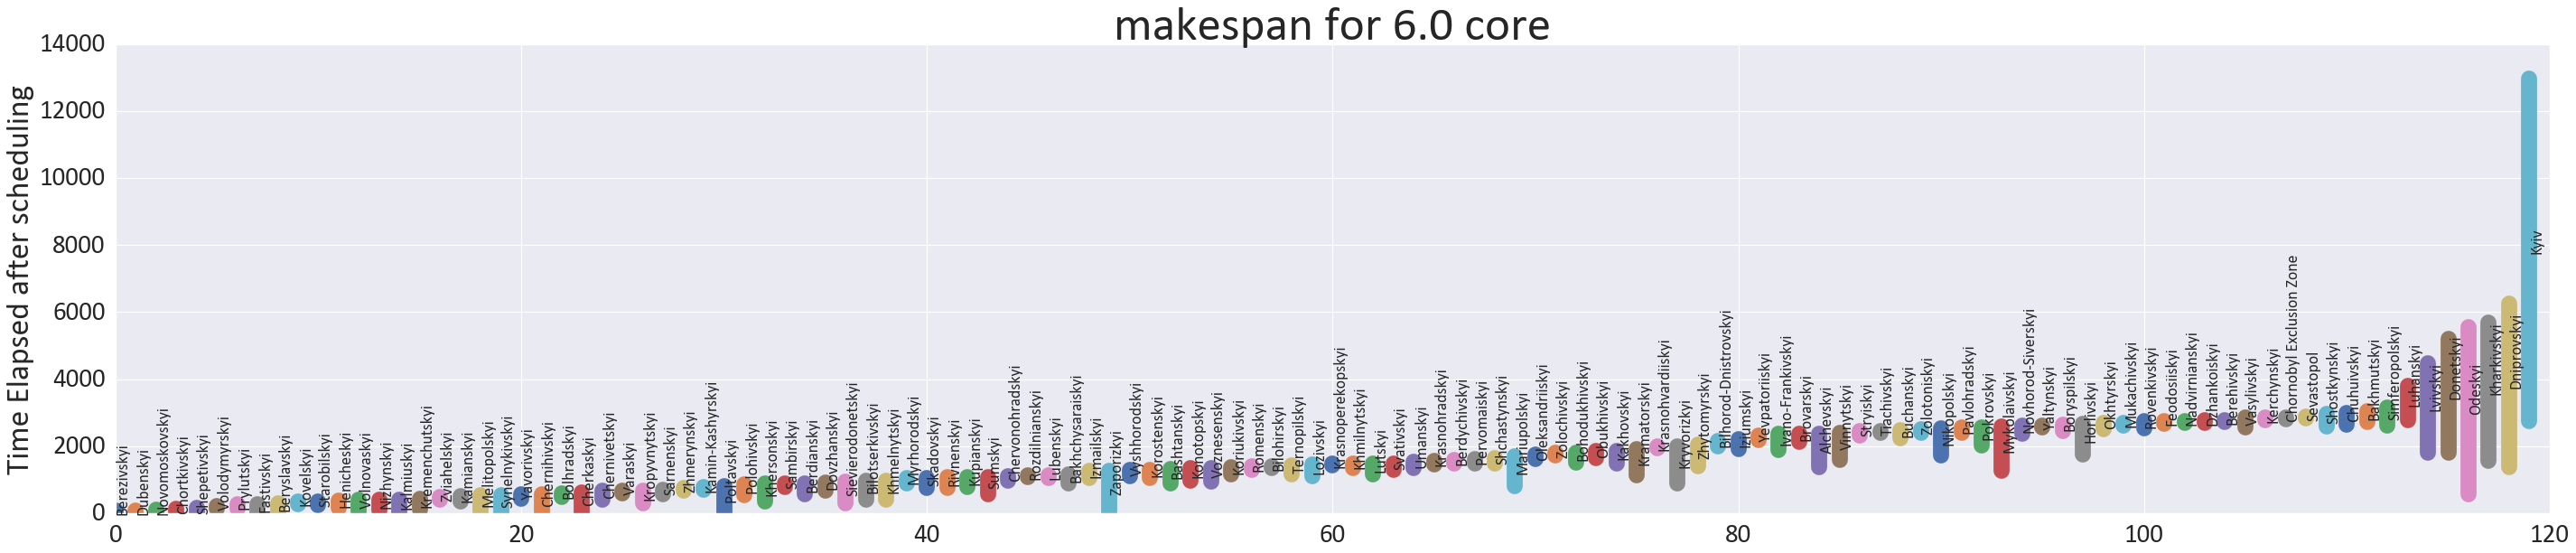

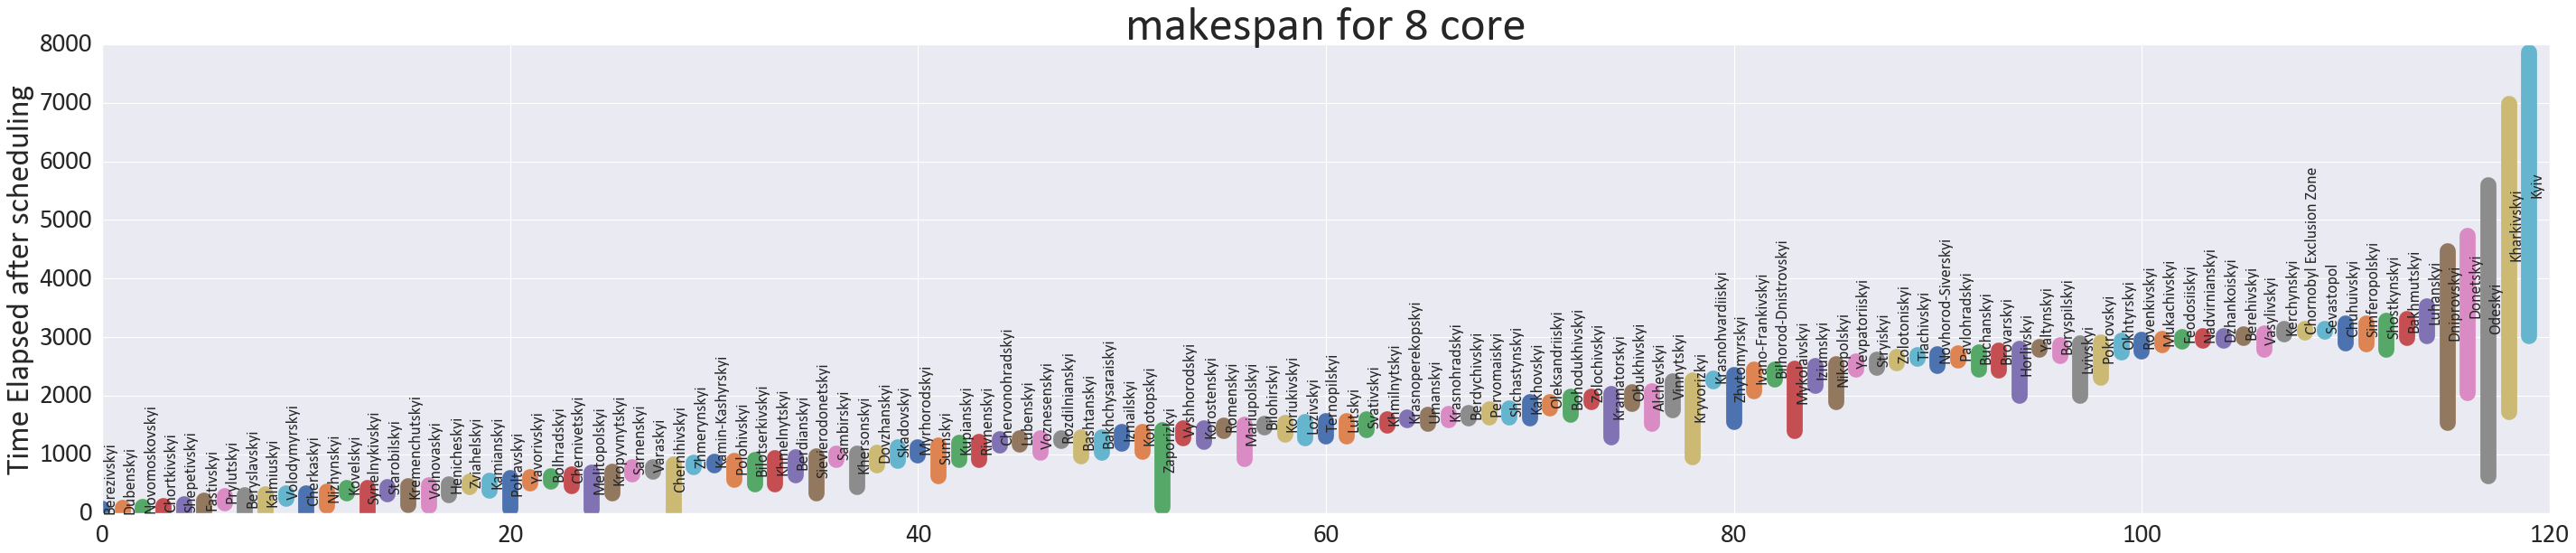

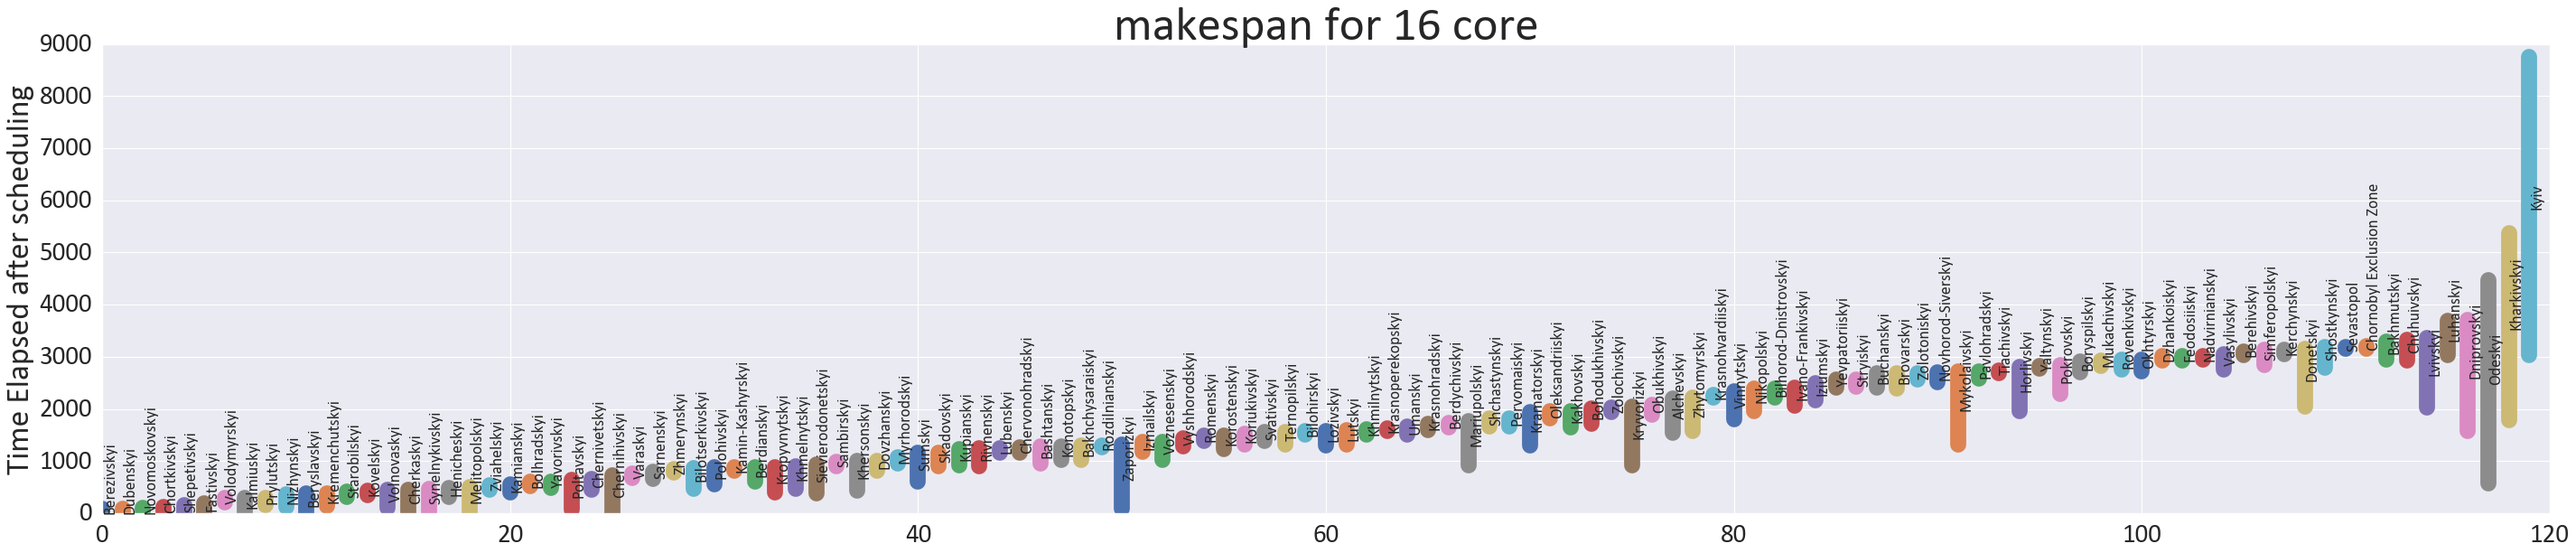

In [17]:
import warnings
warnings.filterwarnings('ignore')
for idx,i in enumerate([99960,99961,99962,99964,99966,99968,99969]):
    print(round(2**sq_i[idx],0),'core')
    cur_runtime_df = runtime_df[runtime_df.hyper_comb==i]
    cur_runtime_df['start_time'] = cur_runtime_df['end_time']-cur_runtime_df['runtime']
    mntime = min(cur_runtime_df['start_time'].min(),cur_runtime_df['end_time'].min())
    cur_runtime_df['start_time'] = cur_runtime_df['start_time']-mntime
    cur_runtime_df['end_time'] = cur_runtime_df['end_time']-mntime
    fig,ax = plt.subplots(figsize=(36,8))
    start_list = cur_runtime_df['start_time'].tolist()
    end_list = cur_runtime_df['end_time'].tolist()
    raion_list = cur_runtime_df['raion'].tolist()
    
    for ll in range(0,len(start_list)):
        ax.plot([ll,ll],[start_list[ll],end_list[ll]],linewidth=16)
        #ax.annotate(raion_list[ll],(ll,,fontsize=8)
        ax.text(x=ll, y=(start_list[ll]+end_list[ll])/2, s=raion_list[ll], rotation=90, fontsize=16)
    ax.set_title('makespan for '+str(round(2**sq_i[idx],0))+' core',fontsize=48)
    ax.set_ylabel('Time Elapsed after scheduling',fontsize=32)
    fig.tight_layout()

## Makespan with different cores

In [18]:
import warnings
warnings.filterwarnings('ignore')

#runs = [99983,99984,99980,99981]
#core_val = [1,2,4,8]

#runs = [99983,99971,99972,99973,99974]
#core_val = [1,2,4,8,16]
runs = [99960,99961,99962,99964,99966,99968,99969]
core_val = ['Hybrid','1','2','4','6','8','16']

dict_core_run = {}
for i in range(len(runs)):
    print(i)
    dict_core_run[runs[i]] = core_val[i]

makespn_df = []

# runtime_df = pd.read_csv('../runtime_log/runtime_raion.csv')
# runtime_df = runtime_df.drop_duplicates(subset=['raion','hyper_comb'],keep='last')

# for run_id in runs[0:3]:
#     cur_df = runtime_df[runtime_df.hyper_comb==run_id]
#     print(cur_df.shape,cur_df['end_time'].max(),cur_df['start_time'].min())
#     makespan = cur_df['end_time'].max()-cur_df['start_time'].min()
#     makespn_df.append(makespan/60)


runtime_df = pd.read_csv('../runtime_log/runtime_raion_for_paper.csv')
runtime_df = runtime_df.drop_duplicates(subset=['raion','hyper_comb'],keep='last')

for run_id in runs:
    cur_df = runtime_df[runtime_df.hyper_comb==run_id]
    cur_runtime_df['start_time'] = cur_runtime_df['end_time']-cur_runtime_df['runtime']
    #print(cur_df.shape,cur_df['end_time'].max(),cur_df['start_time'].min())
    makespan = cur_df['end_time'].max()-cur_df['start_time'].min()
    print(makespan)
    makespn_df.append(makespan/60)



0
1
2
3
4
5
6
7040.363099813461
20348.873377799988
19345.25264787674
13297.875225305557
12928.943677186966
7818.406498193741
8716.84678888321


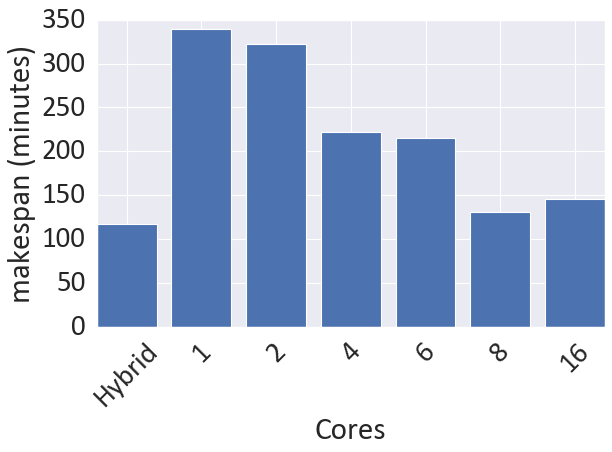

In [19]:
fig,ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45)
ax.bar(core_val,makespn_df)
ax.set_xlabel('Cores')
#ax.set_xticks([0,1,2,4,6,8,16])
ax.set_ylabel('makespan (minutes)')
fig.tight_layout()

## max waiting time for jobs

662.2403047084808
8050.839212179184
6586.168663740158
3723.4144670963287
2823.3607201576233
3103.113250732422
3150.9666831493378


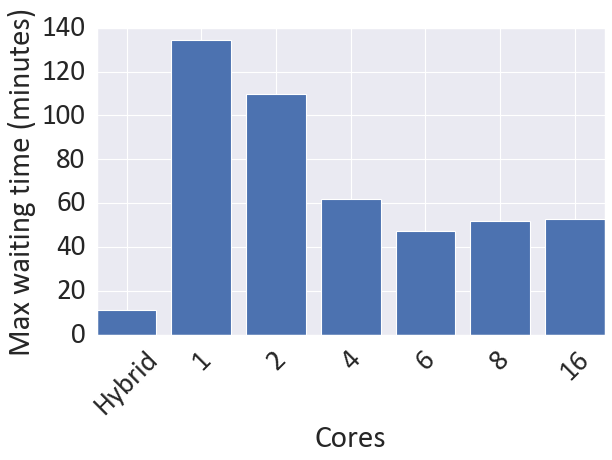

In [20]:
import warnings
warnings.filterwarnings('ignore')

#runs = [99983,99984,99980,99981]
#core_val = [1,2,4,8]

#runs = [99983,99971,99972,99973,99974]
#core_val = [1,2,4,8,16]
runs = [99960,99961,99962,99964,99966,99968,99969]
core_val = ['Hybrid','1','2','4','6','8','16']

dict_core_run = {}
for i in range(len(runs)):
    dict_core_run[runs[i]] = core_val[i]

makespn_df = []

# runtime_df = pd.read_csv('../runtime_log/runtime_raion.csv')
# runtime_df = runtime_df.drop_duplicates(subset=['raion','hyper_comb'],keep='last')

# for run_id in runs[0:3]:
#     cur_df = runtime_df[runtime_df.hyper_comb==run_id]
#     print(cur_df.shape,cur_df['end_time'].max(),cur_df['start_time'].min())
#     makespan = cur_df['end_time'].max()-cur_df['start_time'].min()
#     makespn_df.append(makespan/60)


runtime_df = pd.read_csv('../runtime_log/runtime_raion_for_paper.csv')
runtime_df = runtime_df.drop_duplicates(subset=['raion','hyper_comb'],keep='last')

for run_id in runs:
    cur_df = runtime_df[runtime_df.hyper_comb==run_id]
    cur_df['start_time'] = cur_df['end_time']-cur_df['runtime']
    #print(cur_df.shape,cur_df['end_time'].max(),cur_df['start_time'].min())
    makespan = cur_df['start_time'].max()-cur_df['start_time'].min()
    print(makespan)
    makespn_df.append(makespan/60)

fig,ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation=45)
ax.bar(core_val,makespn_df)
ax.set_xlabel('Cores')
#ax.set_xticks([0,1,2,4,6,8,16])
ax.set_ylabel('Max waiting time (minutes)')
fig.tight_layout()

## multiproc analysis

99969    120
99968    120
99966    120
99964    120
99962    120
99961    120
Name: hyper_comb, dtype: int64


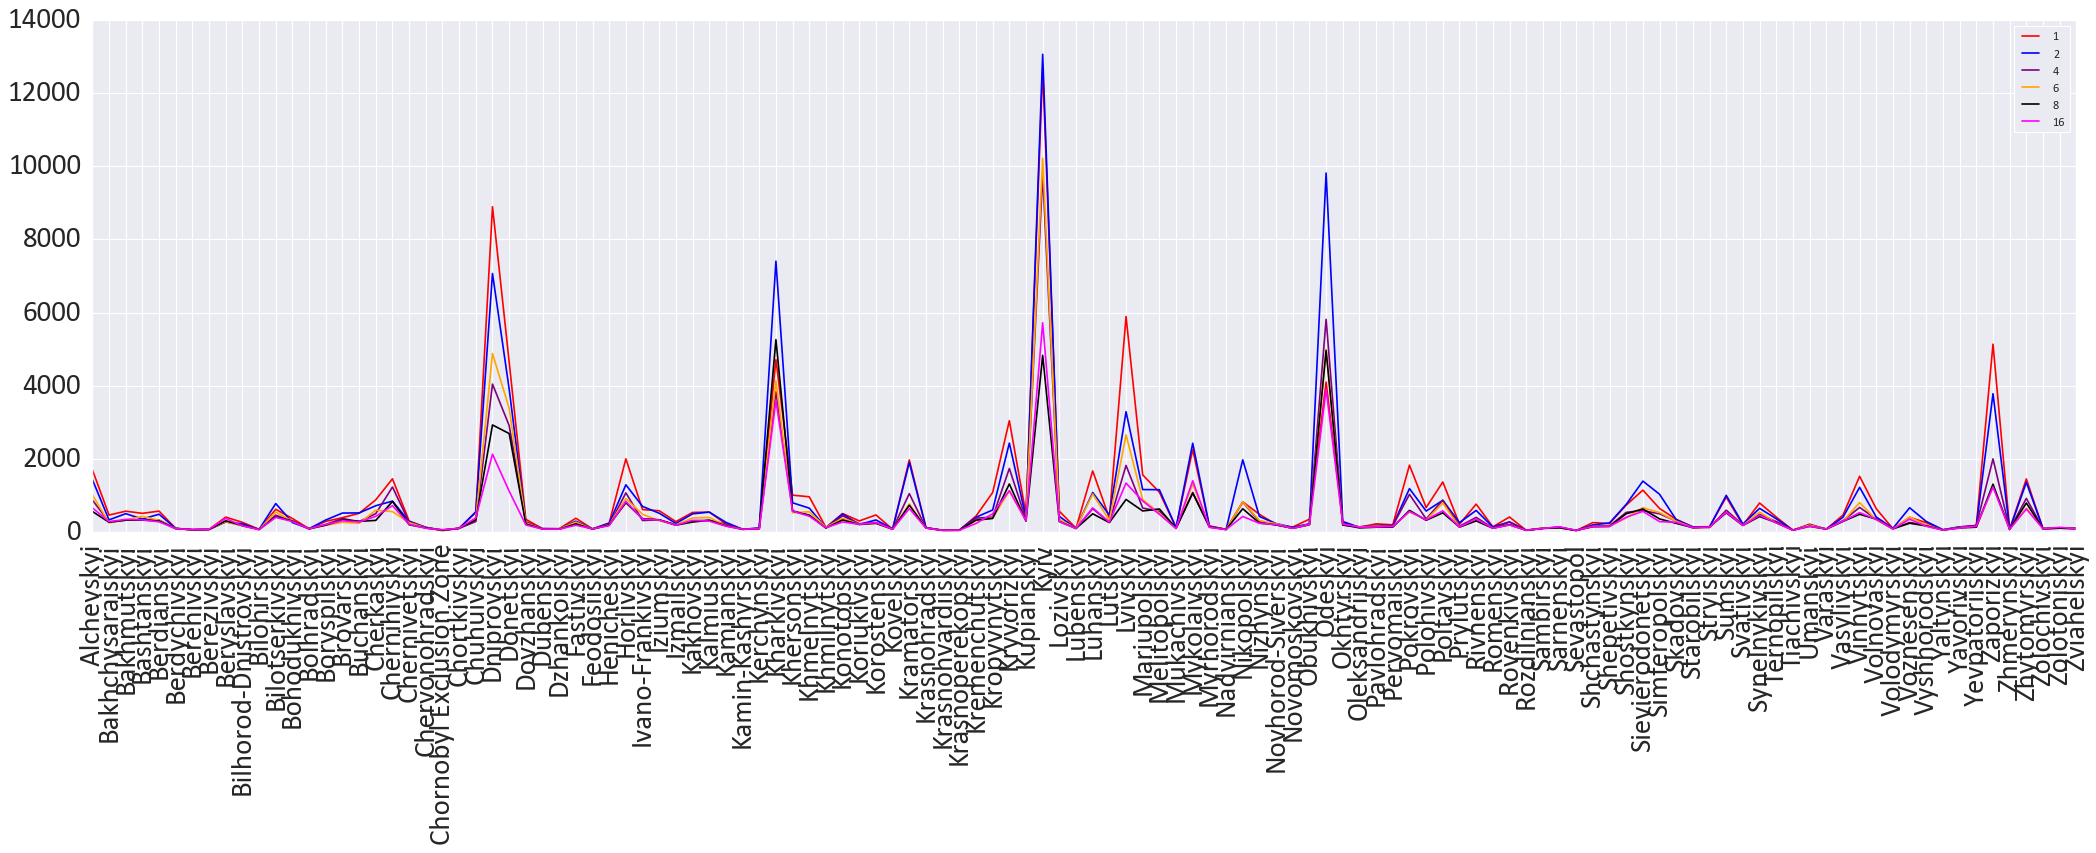

In [27]:
runtime_df = pd.read_csv('../runtime_log/runtime_raion_for_paper.csv')
runtime_df = runtime_df.drop_duplicates(subset=['raion','hyper_comb'],keep='last')

simulation_indices = [99961,99962,99964,99966,99968,99969]
color_idx = ['red','blue','purple','orange','black','magenta']
label = [1,2,4,6,8,16]

fig,ax = plt.subplots(figsize=(32,8))
plt.xticks(rotation=90)
rcParams["font.size"] = 24

check_comb_df = runtime_df[runtime_df.hyper_comb.isin(simulation_indices)]
check_comb_df = check_comb_df.drop_duplicates(subset=['hyper_comb','raion'],keep='last')
print(check_comb_df['hyper_comb'].value_counts())
check_comb_df = check_comb_df.pivot(index='raion',columns='hyper_comb',values='runtime').reset_index().fillna(20000)
check_comb_df 

for i in range(len(simulation_indices)):
    idx = simulation_indices[i]
    lab = label[i]
    ax.plot(check_comb_df['raion'],check_comb_df[idx],label=lab,color=color_idx[i])

ax.legend(loc='best')
check_comb_df = check_comb_df.set_index('raion')

In [28]:
c_list = check_comb_df.columns.tolist()
for i in range(len(simulation_indices)):
    cc = simulation_indices[i]
    new_cc = label[i]
    check_comb_df = check_comb_df.rename(columns={cc:new_cc})
    
check_comb_df

hyper_comb                 1            2           4            6   \
raion                                                                 
Alchevskyi        1702.584081  1435.264457  873.910978  1014.847656   
Bakhchysaraiskyi   463.531238   331.239830  272.138235   249.786228   
Bakhmutskyi        569.362219   501.810106  323.941104   333.798463   
Bashtanskyi        510.460525   354.944665  332.049408   426.944583   
Berdianskyi        571.560143   486.138436  327.662309   317.322967   
...                       ...          ...         ...          ...   
Zhmerynskyi         77.578886    69.189339   75.004698    72.844338   
Zhytomyrskyi      1451.589317  1359.369896  919.251794   652.626498   
Zolochivskyi        84.645734    95.821507   91.168028    90.304305   
Zolotoniskyi       113.675443   116.099250  102.545946   108.147884   
Zviahelskyi        104.132065    93.857643   95.425519    92.203586   

hyper_comb                8           16  
raion                                     
Alchevskyi        562.398600  661.295983  
Bakhchysaraiskyi  266.973592  282.707634  
Bakhmutskyi       325.323824  344.299858  
Bashtanskyi       325.374502  332.562774  
Berdianskyi       302.280546  278.193384  
...                      ...         ...  
Zhmerynskyi        72.740835   74.603658  
Zhytomyrskyi      793.633811  629.175865  
Zolochivskyi       88.609238   90.593303  
Zolotoniskyi      106.812066  127.523699  
Zviahelskyi        90.213364   90.784968  

[120 rows x 6 columns]

In [35]:
#check_comb_df = check_comb_df.set_index('raion')
t_df =  check_comb_df.T
for col in t_df.columns.tolist():
    t_df[col] = t_df[col].rank(ascending=False)
t_df

raion       Alchevskyi  Bakhchysaraiskyi  Bakhmutskyi  Bashtanskyi  \
hyper_comb                                                           
1                  6.0               6.0          6.0          6.0   
2                  5.0               5.0          5.0          4.0   
4                  3.0               3.0          1.0          2.0   
6                  4.0               1.0          3.0          5.0   
8                  1.0               2.0          2.0          1.0   
16                 2.0               4.0          4.0          3.0   

raion       Berdianskyi  Berdychivskyi  Berehivskyi  Berezivskyi  \
hyper_comb                                                         
1                   6.0            5.0          4.0          2.0   
2                   5.0            6.0          5.0          5.0   
4                   4.0            4.0          2.0          3.0   
6                   3.0            3.0          1.0          4.0   
8                   2.0            2.0          3.0          1.0   
16                  1.0            1.0          6.0          6.0   

raion       Beryslavskyi  Bilhorod-Dnistrovskyi  ...  Vyshhorodskyi  \
hyper_comb                                       ...                  
1                    6.0                    6.0  ...            5.0   
2                    1.0                    5.0  ...            6.0   
4                    2.0                    3.0  ...            3.0   
6                    3.0                    1.0  ...            4.0   
8                    4.0                    4.0  ...            2.0   
16                   5.0                    2.0  ...            1.0   

raion       Yaltynskyi  Yavorivskyi  Yevpatoriiskyi  Zaporizkyi  Zhmerynskyi  \
hyper_comb                                                                     
1                  4.0          5.0             6.0         6.0          6.0   
2                  6.0          6.0             4.0         5.0          1.0   
4                  2.0          3.0             5.0         4.0          5.0   
6                  3.0          4.0             2.0         2.0          3.0   
8                  5.0          2.0             1.0         3.0          2.0   
16                 1.0          1.0             3.0         1.0          4.0   

raion       Zhytomyrskyi  Zolochivskyi  Zolotoniskyi  Zviahelskyi  
hyper_comb                                                         
1                    6.0           1.0           4.0          6.0  
2                    5.0           6.0           5.0          4.0  
4                    4.0           5.0           1.0          5.0  
6                    2.0           3.0           3.0          3.0  
8                    3.0           2.0           2.0          1.0  
16                   1.0           4.0           6.0          2.0  

[6 rows x 120 columns]

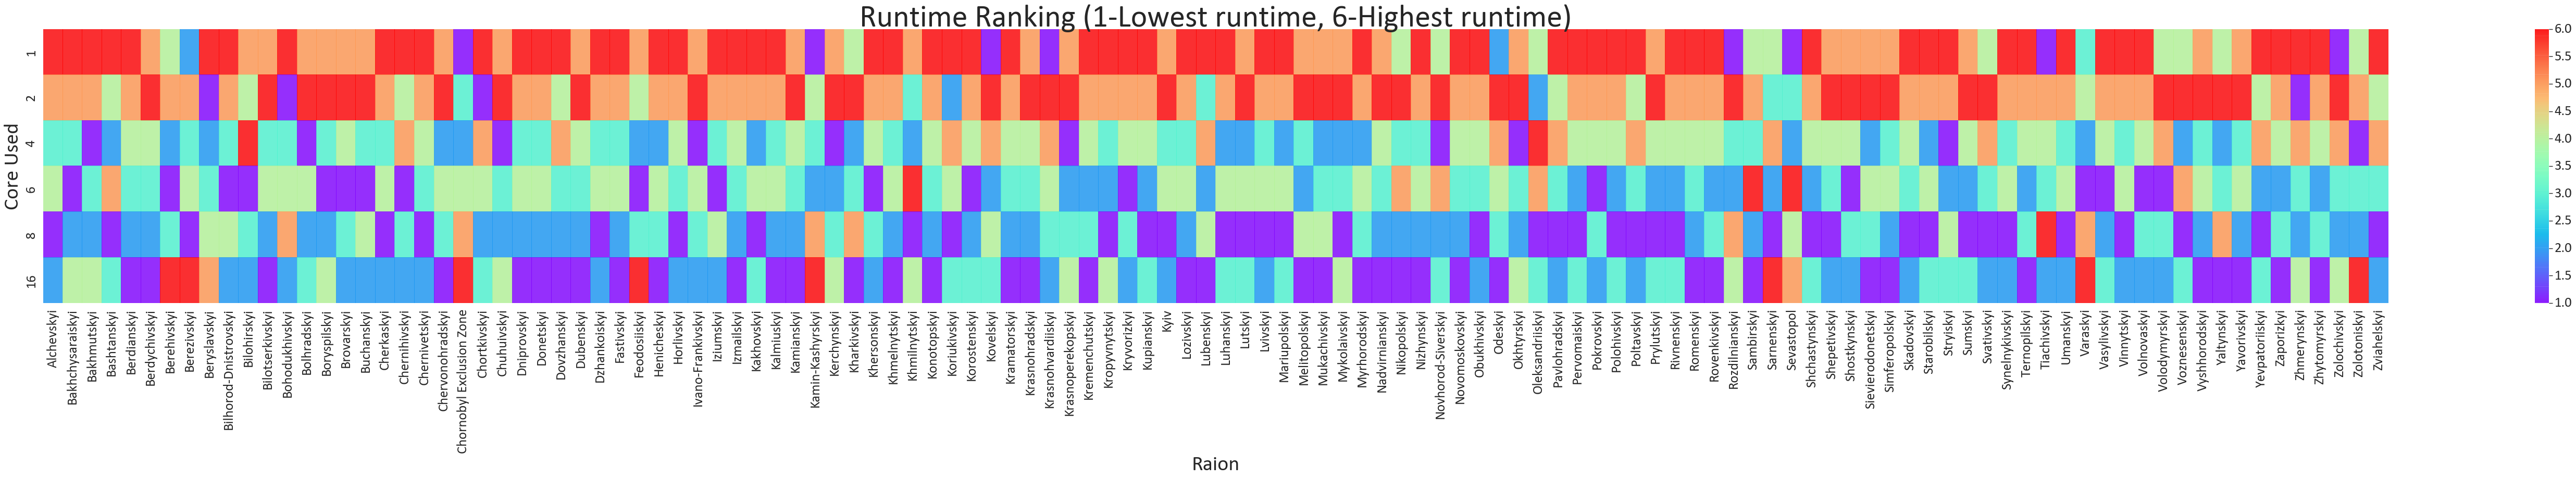

In [46]:
import seaborn as sns
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 24
#rcParams["axes.labelsize"] = 24
#rcParams["axes.titlesize"] = 24
#rcParams["xtick.labelsize"] = 24
#rcParams["ytick.labelsize"] = 24
fig,ax = plt.subplots(figsize=(72,12))
sns.heatmap(t_df,ax=ax,cmap='rainbow',alpha=0.8)
ax.set_title('Runtime Ranking (1-Lowest runtime, 6-Highest runtime)',fontsize=54)
ax.set_xlabel('Raion',fontsize=36)
ax.set_ylabel('Core Used',fontsize=36)
fig.tight_layout()

99969    120
99968    120
99966    120
99964    120
99962    120
99961    120
Name: hyper_comb, dtype: int64


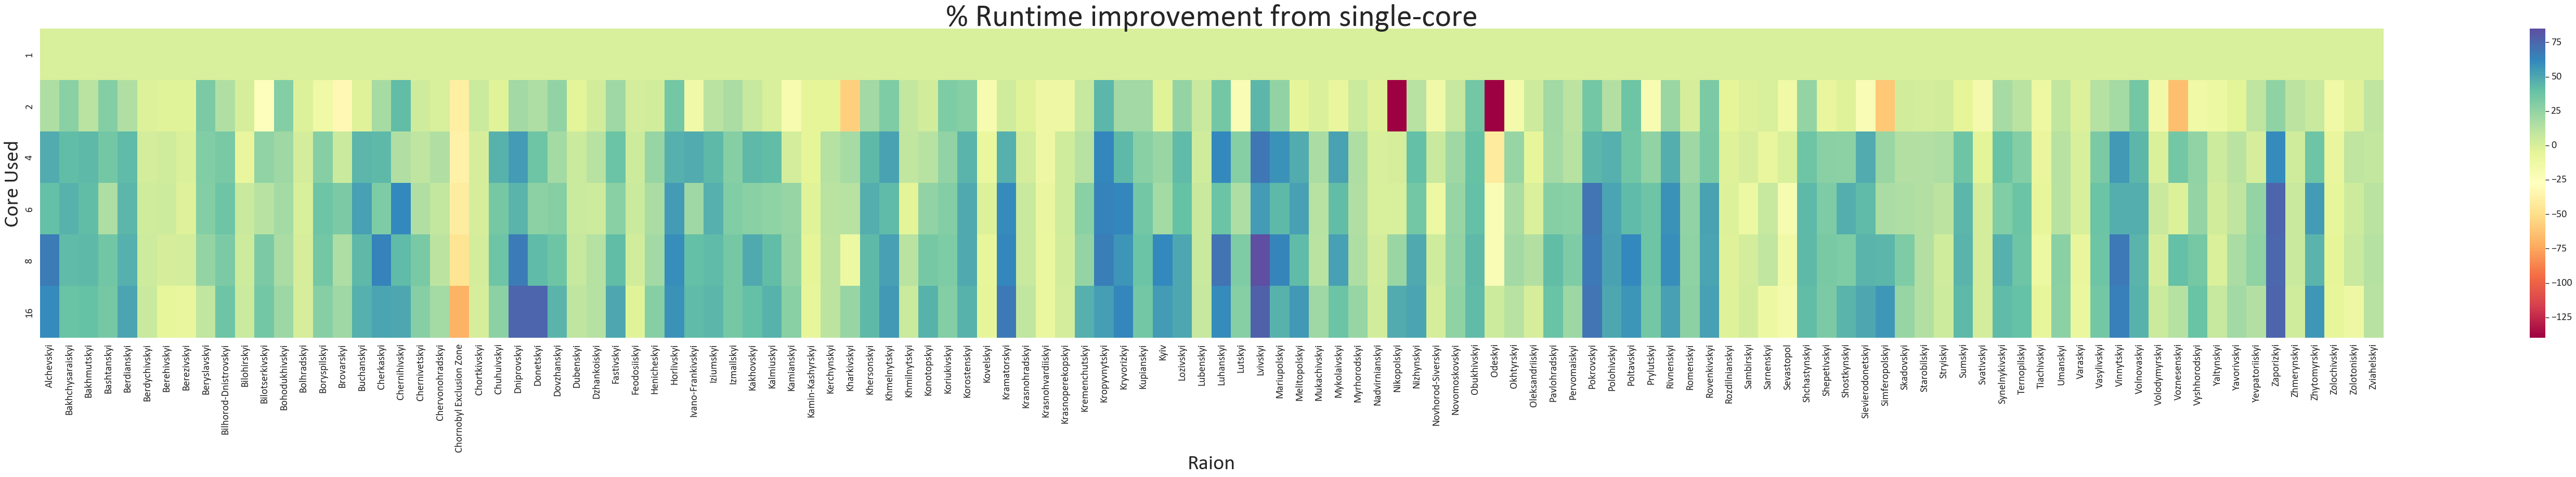

In [51]:
runtime_df = pd.read_csv('../runtime_log/runtime_raion_for_paper.csv')
runtime_df = runtime_df.drop_duplicates(subset=['raion','hyper_comb'],keep='last')

simulation_indices = [99961,99962,99964,99966,99968,99969]
color_idx = ['red','blue','purple','orange','black','magenta']
label = [1,2,4,6,8,16]

check_comb_df = runtime_df[runtime_df.hyper_comb.isin(simulation_indices)]
check_comb_df = check_comb_df.drop_duplicates(subset=['hyper_comb','raion'],keep='last')
print(check_comb_df['hyper_comb'].value_counts())
check_comb_df = check_comb_df.pivot(index='raion',columns='hyper_comb',values='runtime').reset_index().fillna(20000)
check_comb_df = check_comb_df.set_index('raion')

c_list = check_comb_df.columns.tolist()
for i in range(len(simulation_indices)):
    cc = simulation_indices[i]
    new_cc = label[i]
    check_comb_df = check_comb_df.rename(columns={cc:new_cc})
    
#check_comb_df = check_comb_df.set_index('raion')
t_df =  check_comb_df.T
for cc in [2,4,6,8,16]:
    t_df.loc[cc] = 100*(t_df.loc[1.0]-t_df.loc[cc])/(t_df.loc[1.0])
for cc in [1]:
    t_df.loc[cc] = 100*(t_df.loc[cc]-t_df.loc[1.0])/(t_df.loc[1.0])
t_df = t_df.sort_index()
t_df

import seaborn as sns
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 24
fig,ax = plt.subplots(figsize=(72,12))

sns.heatmap(t_df,ax=ax,cmap='Spectral')
ax.set_title('% Runtime improvement from single-core',fontsize=54)
ax.set_xlabel('Raion',fontsize=36)
ax.set_ylabel('Core Used',fontsize=36)
fig.tight_layout()


In [49]:

all_timing_files =   [ f for f in os.listdir(OUTPUT_DIR) if f.startswith('timing_log') and '9996' in f]


In [33]:
len(all_timing_files) 

1191

In [55]:
# all_dfs = []
# for idx in [99992,99993,99994,99995]:
#     for f in all_timing_files:
#         if f.startswith('timing_log_Kyiv') and f.endswith(str(idx).zfill(5)+'.csv'):
#             df = pd.read_csv(OUTPUT_DIR+f)
#             all_dfs.append(df)
            
# sample_attitude = pd.concat(all_dfs).sort_values(by='step')
# #sample_attitude = sample_attitude[sample_attitude.step<=20]
# print(sample_attitude.shape)
# fig,ax = plt.subplots(figsize=(8,6))
# ax.scatter((sample_attitude['remaining_person_agent']*sample_attitude['conflict_events_now'])/1e6,sample_attitude['attitude_time'],color='red',label='1 core')

# all_dfs = []
# for idx in [99991,99982,99983,99984,99985]:
#     for f in all_timing_files:
#         if f.startswith('timing_log_Kyiv') and f.endswith(str(idx).zfill(5)+'.csv'):
#             df = pd.read_csv(OUTPUT_DIR+f)
#             all_dfs.append(df)
            
# sample_attitude = pd.concat(all_dfs).sort_values(by='step')
# #sample_attitude = sample_attitude[sample_attitude.step<=20]
# print(sample_attitude.shape)
# #fig,ax = plt.subplots(figsize=(6,6))
# ax.scatter((sample_attitude['remaining_person_agent']*sample_attitude['conflict_events_now'])/1e6,sample_attitude['attitude_time'],color='blue',label='8 cores')

# ax.set_xlabel('EVENT X AGENT (M)')
# ax.set_ylabel('Runtime of Attitude Phase(S)')
# ax.legend(loc='best',fontsize=18)

(6537, 11)
(6537, 11)
(6537, 11)
(6460, 11)
(6537, 11)
(6537, 11)


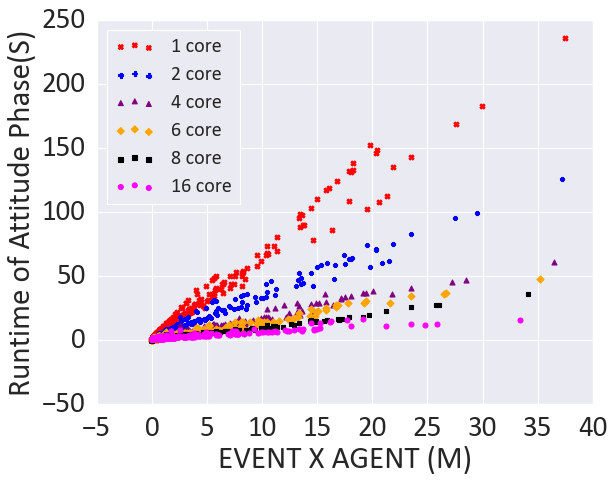

In [38]:
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(8,6))
simulation_indices = [99961,99962,99964,99966,99968,99969]
color_idx = ['red','blue','purple','orange','black','magenta']
label = [1,2,4,6,8,16]
markers = ['X','P','^','D','s','o']

for k,idx in enumerate(simulation_indices):
    all_dfs = []
    for f in all_timing_files:
        if f.endswith(str(idx).zfill(5)+'.csv'):
            df = pd.read_csv(OUTPUT_DIR+f)
            all_dfs.append(df)
            
    sample_attitude = pd.concat(all_dfs).sort_values(by='step')
    #sample_attitude = sample_attitude[sample_attitude.step<=20]
    print(sample_attitude.shape)
    ax.scatter((sample_attitude['remaining_person_agent']*sample_attitude['conflict_events_now'])/1e6,sample_attitude['attitude_time'],
               marker=markers[k],color=color_idx[k],label=str(label[k])+' core')

ax.set_xlabel('EVENT X AGENT (M)')
ax.set_ylabel('Runtime of Attitude Phase(S)')
ax.legend(loc='best',fontsize=18)

(6537, 11)
(6537, 11)
(6537, 11)
(6460, 11)
(6537, 11)
(6537, 11)


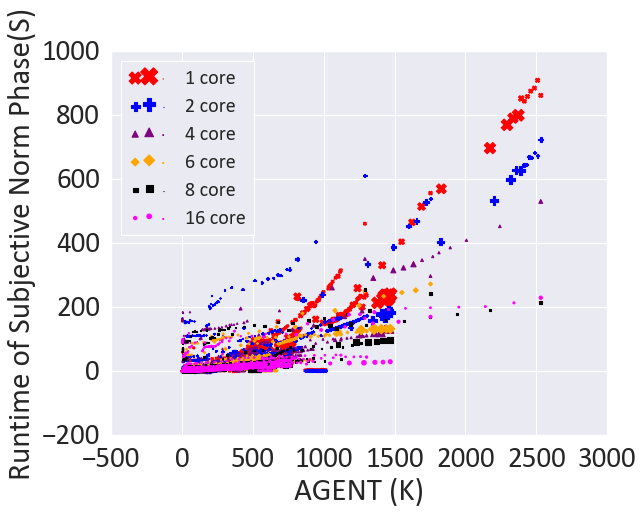

In [39]:
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

ig,ax = plt.subplots(figsize=(8,6))
simulation_indices = [99961,99962,99964,99966,99968,99969]
color_idx = ['red','blue','purple','orange','black','magenta']
label = [1,2,4,6,8,16]
markers = ['X','P','^','D','s','o']

for k,idx in enumerate(simulation_indices):
    all_dfs = []
    for f in all_timing_files:
        if f.endswith(str(idx).zfill(5)+'.csv'):
            df = pd.read_csv(OUTPUT_DIR+f)
            all_dfs.append(df)
            
    sample_attitude = pd.concat(all_dfs).sort_values(by='step')
    #sample_attitude = sample_attitude[sample_attitude.step<=20]
    print(sample_attitude.shape)
    ax.scatter((sample_attitude['remaining_person_agent'])/1e3,sample_attitude['subjective_norm_time'],sample_attitude['attitude_time'],
               marker=markers[k],color=color_idx[k],label=str(label[k])+' core')

ax.set_xlabel('AGENT (K)')
ax.set_ylabel('Runtime of Subjective Norm Phase(S)')
ax.legend(loc='best',fontsize=18)

In [39]:
## extra lines for core testing
ll = ['Melitopolskyi', 'Kharkivskyi', 'Zhytomyrskyi', 'Odeskyi', 'Yevpatoriiskyi', 'Oleksandriiskyi', 'Bakhchysaraiskyi', 'Kropyvnytskyi', 'Buchanskyi']
core_1 = '99983 3.67 23.33 0.78 98.67 7 7 0.35476579044948314 0.3334514152024192 40 2 17 13 1 5 0.3 40 1.0 1.8 1'
core_2 = '99984 3.67 23.33 0.78 98.67 7 7 0.35661541942904823 0.34725276424445384 40 2 18 13 1 5 0.3 40 1.0 1.8 2'
core_4 = '99980 3.67 23.33 0.78 98.67 7 7 0.3426890681641343 0.33980842273884465 40 2 17 13 1 5 0.3 40 1.0 1.8 4'
core_8 = '99981 3.67 23.33 0.78 98.67 7 7 0.3488062616648471 0.3385052283454865 40 2 15 13 1 5 0.3 40 1.0 1.8 8'
core_16 = '99982 3.67 23.33 0.78 98.67 7 7 0.34744310896961683 0.33515854047571636 40 2 15 13 1 5 0.3 40 1.0 1.8 16'
all_cores = [core_1, core_2, core_4, core_8, core_16]
core = [1,2,4,8,16]
for i in range(len(all_cores)):
    params = all_cores[i]
    cc = core[i]
    for raion in ll:
        mm = raion_df[raion_df.Raion==raion].iloc[0]['mem_need']
        print('sbatch --mem='+str(mm*2)+" --cpus-per-task="+str(cc)+" ukr_mim_mdm_sample.sbatch "+str(raion)+" "+params)
    print(' ')

sbatch --mem=16000 --cpus-per-task=1 ukr_mim_mdm_sample.sbatch Melitopolskyi 99983 3.67 23.33 0.78 98.67 7 7 0.35476579044948314 0.3334514152024192 40 2 17 13 1 5 0.3 40 1.0 1.8 1
sbatch --mem=256000 --cpus-per-task=1 ukr_mim_mdm_sample.sbatch Kharkivskyi 99983 3.67 23.33 0.78 98.67 7 7 0.35476579044948314 0.3334514152024192 40 2 17 13 1 5 0.3 40 1.0 1.8 1
sbatch --mem=32000 --cpus-per-task=1 ukr_mim_mdm_sample.sbatch Zhytomyrskyi 99983 3.67 23.33 0.78 98.67 7 7 0.35476579044948314 0.3334514152024192 40 2 17 13 1 5 0.3 40 1.0 1.8 1
sbatch --mem=256000 --cpus-per-task=1 ukr_mim_mdm_sample.sbatch Odeskyi 99983 3.67 23.33 0.78 98.67 7 7 0.35476579044948314 0.3334514152024192 40 2 17 13 1 5 0.3 40 1.0 1.8 1
sbatch --mem=16000 --cpus-per-task=1 ukr_mim_mdm_sample.sbatch Yevpatoriiskyi 99983 3.67 23.33 0.78 98.67 7 7 0.35476579044948314 0.3334514152024192 40 2 17 13 1 5 0.3 40 1.0 1.8 1
sbatch --mem=16000 --cpus-per-task=1 ukr_mim_mdm_sample.sbatch Oleksandriiskyi 99983 3.67 23.33 0.78 98.67